# Soil Moisture Plots

These are the plot types that people came up with on Dec. 8 that will be discussed on Dec. 17 or Dec. 18.

In [2]:
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial

import math
import datetime
from datetime import date
import datetime
import time


import scipy
import os, os.path
import itertools
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/Stop_the_Rot/')
import onion_core as oc
import onion_plot_core as opc

In [3]:
data_dir = "/Users/hn/Documents/01_research_data/Stop_the_Rot/files_from_team/Columbia_Basin_Farm_A_red_onion_data/"
python_data_dir = "/Users/hn/Documents/01_research_data/Stop_the_Rot/Clean_For_Python/"

# Read weather data

In [5]:
ABC_2016_2017 = oc.read_ABC_weather_XLSfile(an_add_fileName = python_data_dir + "ABC_Correct.xlsx", 
                                            header_rows = 1, 
                                            skip_Rows = 3)

In [7]:
ABC_2016_2017.head(2)

,Date,Max Temp (F),Min Temp (F),Average Temp (F),Dew Point,Rain (Inch),Wind (Miles),Solar (rad),ETp,GDD,Unnamed: 10
0,2016-11-01 00:00:00,63,41,52,43,0,99,303,0.07,6.35,NaN
1,2016-11-02 00:00:00,64,41,53,44,0,28,272,0.05,7.15,NaN


# We have to do this next step since we updated the damn Pandas

In [16]:
ABC_2016_2017['Date'] = pd.to_datetime(ABC_2016_2017.Date, format='%Y-%m-%d %H:%M:%S')
ABC_2016_2017['Date'] = ABC_2016_2017['Date'].dt.strftime('%Y-%m-%d')
ABC_2016_2017['Date'] = pd.to_datetime(ABC_2016_2017.Date, format='%Y-%m-%d')

In [20]:
ABC_2016_2017['month'] = ABC_2016_2017['Date'].dt.month
ABC_2016_2017['year'] = ABC_2016_2017['Date'].dt.year

In [22]:
ABC_2016_2017.head(2)

,Date,Max Temp (F),Min Temp (F),Average Temp (F),Dew Point,Rain (Inch),Wind (Miles),Solar (rad),ETp,GDD,Unnamed: 10,month,year
0,2016-11-01,63,41,52,43,0,99,303,0.07,6.35,NaN,11,2016
1,2016-11-02,64,41,53,44,0,28,272,0.05,7.15,NaN,11,2016


# Take care of the damn DEW column and `\xad` rows (strings)

This fix temporaty. I need to find a way to detect this type of string with `\xad` in it and take care of it:

https://stackoverflow.com/questions/51976328/best-way-to-remove-xad-in-python

In [25]:
import re

In [26]:
# convert the damn strings to -10

ABC_2016_2017["Dew Point"] = ABC_2016_2017["Dew Point"].astype(str)

# convert the damn strings to -10
# for ii in np.arange(len(ABC_2016_2017.index)):
#     if ABC_2016_2017.loc[ii, "Dew Point"][0] == '\xad':
#         ABC_2016_2017.loc[ii, "Dew Point"] = '-10'

# remove the soft-hyphen
#
for ii in np.arange(len(ABC_2016_2017.index)):
    if ABC_2016_2017.loc[ii, "Dew Point"][0] == '\xad':
        ABC_2016_2017.loc[ii, "Dew Point"] = re.sub('\xad','', ABC_2016_2017.loc[ii, "Dew Point"])


ABC_2016_2017["Dew Point"] = ABC_2016_2017["Dew Point"].astype(float)

ABC_2016_2017["Dew Point"].astype(float)

##
## Add celsuis stuff to compute Relative Humidity.
## 
ABC_2016_2017["Avg_Temp_C"] = (ABC_2016_2017["Average Temp (F)"] - 32 ) * (5/9)
ABC_2016_2017["Dew_Point_C"] = (ABC_2016_2017["Dew Point"] - 32 ) * (5/9) 

In [27]:
simple_RH = oc.relative_humidity_simple(ABC_2016_2017)
complex_RH = oc.relative_humidity_complex_1(ABC_2016_2017)

In [28]:
ABC_2016_2017['simple_RH'] = simple_RH
ABC_2016_2017['complex_RH'] = complex_RH
ABC_2016_2017.head(2)

,Date,Max Temp (F),Min Temp (F),Average Temp (F),Dew Point,Rain (Inch),Wind (Miles),Solar (rad),ETp,GDD,Unnamed: 10,month,year,Avg_Temp_C,Dew_Point_C,simple_RH,complex_RH
0,2016-11-01,63,41,52,43.0,0,99,303,0.07,6.35,NaN,11,2016,11.111111,6.111111,75.0,71.302576
1,2016-11-02,64,41,53,44.0,0,28,272,0.05,7.15,NaN,11,2016,11.666667,6.666667,75.0,71.408799


In [29]:
May_2016_TStamp = pd.Timestamp(year=2017, month=5, day=1)
Sep_2017_TStamp = pd.Timestamp(year=2017, month=9, day=1)

# ABC_2016_2017_small_TW is small time window: 
ABC_2016_2017_small_TW = ABC_2016_2017[ABC_2016_2017.Date >= May_2016_TStamp]
ABC_2016_2017_small_TW = ABC_2016_2017_small_TW[ABC_2016_2017_small_TW.Date <= Sep_2017_TStamp]

In [30]:
ABC_2016_2017_small_TW.shape

(93, 17)

# Read Soil Moisture data

In [31]:
file_names = ["CLEANED (3) Real Time Soil Moisture data_Field A1.xlsx", 
              "CLEANED (3) Real Time Soil Moisture data_Field A2.xlsx", 
              "CLEANED (3) Real Time Soil Moisture data_Field A3.xlsx", 
              "CLEANED (3) Real Time Soil Moisture data_Field A4.xlsx",
              "CLEANED (3) Real Time Soil Moisture data_Field A5.xlsx"]

In [33]:
A1 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[0], head_count=0)
A2 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[1], head_count=0)
A3 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[2], head_count=0)
A4 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[3], head_count=0)
A5 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[4], head_count=0)

In [34]:
A1.head(3)

,Date,Sensor1,Sensor2,Sensor3,Sensor4
0,2017-05-12 08:30:12.999997,0.71,0.43,0.34,0.49
1,2017-05-12 09:00:16.000001,0.71,0.43,0.34,0.49
2,2017-05-12 09:30:13.000000,0.71,0.43,0.34,0.49


In [35]:
A1["field"] = "A1"
A2["field"] = "A2"
A3["field"] = "A3"
A4["field"] = "A4"
A5["field"] = "A5"

In [36]:
A1.head(3)

,Date,Sensor1,Sensor2,Sensor3,Sensor4,field
0,2017-05-12 08:30:12.999997,0.71,0.43,0.34,0.49,A1
1,2017-05-12 09:00:16.000001,0.71,0.43,0.34,0.49,A1
2,2017-05-12 09:30:13.000000,0.71,0.43,0.34,0.49,A1


In [37]:
# NewcolNames = [i + j for i, j in zip(["A1_"]*4, ["sensor_1", "sensor_2", "sensor_3", "sensor_4"])]
# NewcolNames = ['Date'] +  NewcolNames + ["field"]
# A1.columns = NewcolNames

In [38]:
print (min(A1.Date))
print (max(A1.Date))
print ("------------------------")
print (min(A2.Date))
print (max(A2.Date))
print ("------------------------")
print (min(A3.Date))
print (max(A3.Date))
print ("------------------------")
print (min(A4.Date))
print (max(A4.Date))
print ("------------------------")
print (min(A5.Date))
print (max(A5.Date))

2017-05-12 08:30:12.999997
2017-08-23 10:00:12.999997
------------------------
2017-05-12 11:48:54.000003
2017-08-18 10:00:04.000003
------------------------
2017-05-05 14:46:43.999997
2017-08-18 10:00:15.999995
------------------------
2017-05-07 00:00:13.999997
2017-08-23 06:00:13.999997
------------------------
2017-05-05 17:56:41.000004
2017-08-23 08:00:11.999998


In [39]:
v = [1, 2 ,3]
print (min(A1.Date))
print (min(A2.Date))
print (min(A3.Date))
print (min(A4.Date))
print (min(A5.Date))

print ("------------------------")

print (max(A1.Date))
print (max(A2.Date))
print (max(A3.Date))
print (max(A4.Date))
print (max(A5.Date))

2017-05-12 08:30:12.999997
2017-05-12 11:48:54.000003
2017-05-05 14:46:43.999997
2017-05-07 00:00:13.999997
2017-05-05 17:56:41.000004
------------------------
2017-08-23 10:00:12.999997
2017-08-18 10:00:04.000003
2017-08-18 10:00:15.999995
2017-08-23 06:00:13.999997
2017-08-23 08:00:11.999998


In [40]:
# print (A1.Date[3] - A1.Date[2])
# A1["Date_col"] = A1.Date
# A1['Date'] = A1['Date'].dt.date # converts timeStamp to datetime and tosses hour minute.

In [41]:
plot_dir = "/Users/hn/Documents/01_research_data/Stop_the_Rot/Plots/Dec17Meeting/"

# Plot all sensors of a field in a subplot

opc.plot_moistures_oneFieldAtaTime(A1, A2, A3, A4, A5, yLabel="inches?", xLabel="", y_limits=[0.2, 1.4])

file_name = plot_dir + "look.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')

plt.show()

'/Users/hn/Documents/01_research_data/Stop_the_Rot/Plots/Dec17Meeting/'

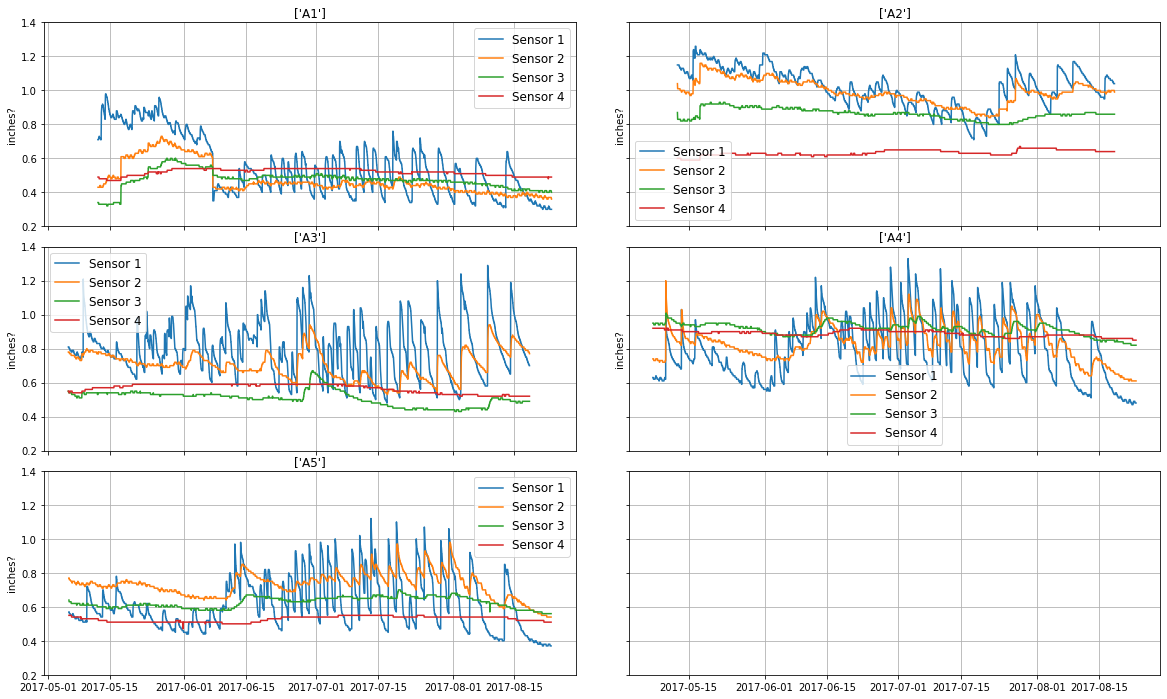

In [20]:
opc.plot_moistures_oneFieldAtaTime(A1, A2, A3, A4, A5, yLabel="inches?", xLabel="", y_limits=[0.2, 1.4])

file_name = plot_dir + "01_sensor_readings_per_field.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

# Plot one sensor (e.g. sensor 1) of all fields in a subplot.

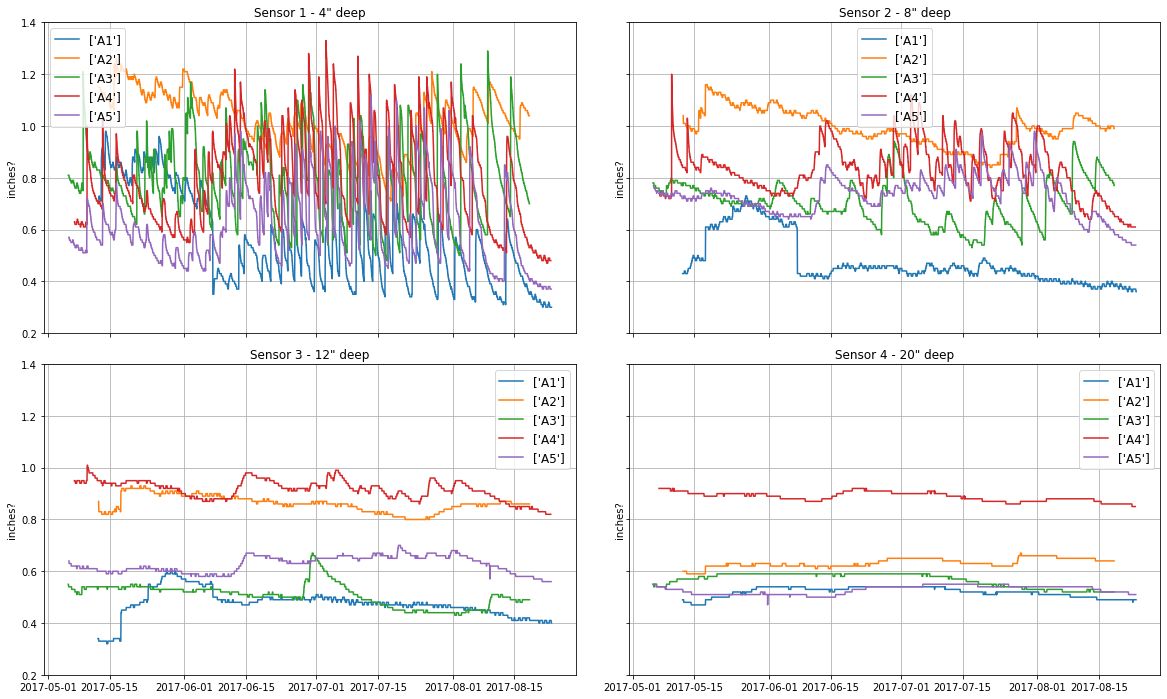

In [21]:
opc.plot_moistures_oneSensorAtaTime(A1, A2, A3, A4, A5, yLabel="inches?", xLabel="", y_limits=[0.2, 1.4])

file_name = plot_dir + "02_sensor_readings_per_sensor.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

# Standardize Moistures

In [22]:
A1_std = A1[["Date", "Sensor1", "Sensor2", "Sensor3", "Sensor4", "field"]].copy()
A2_std = A2[["Date", "Sensor1", "Sensor2", "Sensor3", "Sensor4", "field"]].copy()
A3_std = A3[["Date", "Sensor1", "Sensor2", "Sensor3", "Sensor4", "field"]].copy()
A4_std = A4[["Date", "Sensor1", "Sensor2", "Sensor3", "Sensor4", "field"]].copy()
A5_std = A5[["Date", "Sensor1", "Sensor2", "Sensor3", "Sensor4", "field"]].copy()

all_soilMoistures_std = pd.concat([A1_std, A2_std, A3_std, A4_std, A5_std])
    
all_soilMoistures_std = oc.minMax_standardize_soilMoisture(all_soilMoistures_std)
all_soilMoistures_std.head(2)

A1_std = all_soilMoistures_std[all_soilMoistures_std.field == "A1"].copy()
A2_std = all_soilMoistures_std[all_soilMoistures_std.field == "A2"].copy()
A3_std = all_soilMoistures_std[all_soilMoistures_std.field == "A3"].copy()
A4_std = all_soilMoistures_std[all_soilMoistures_std.field == "A4"].copy()
A5_std = all_soilMoistures_std[all_soilMoistures_std.field == "A5"].copy()

# Plot all sensors of a field in a subplot. Standardized version

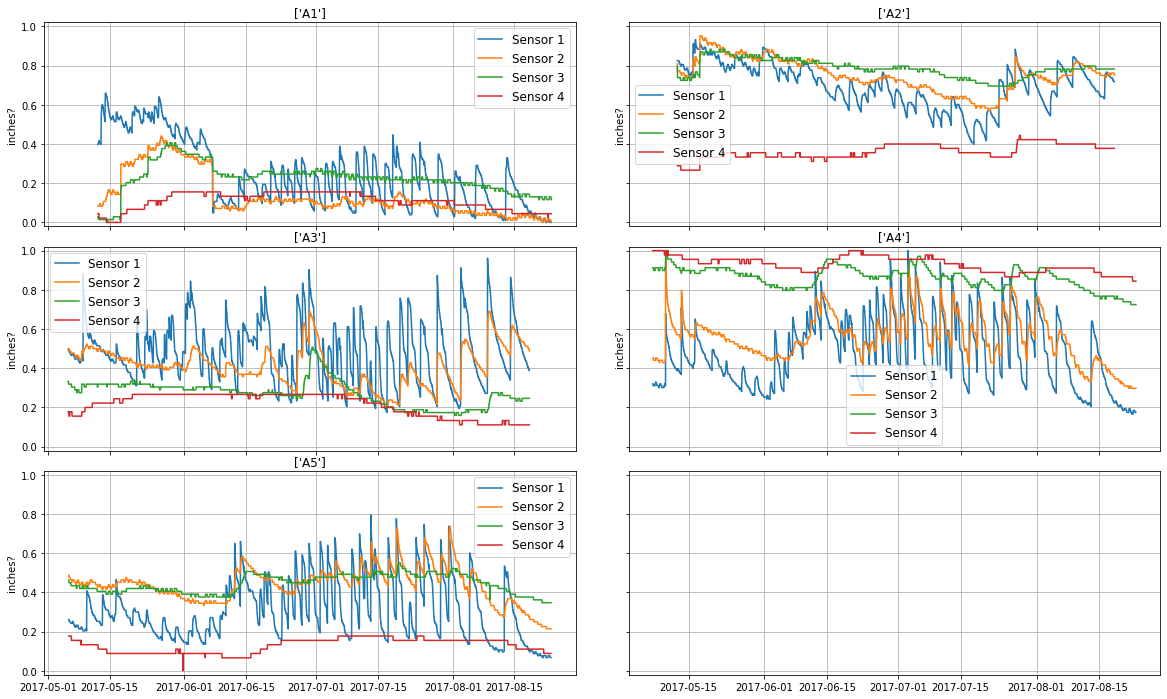

In [23]:
opc.plot_moistures_oneFieldAtaTime(A1_std, A2_std, A3_std, A4_std, A5_std, yLabel="inches?", xLabel="")

file_name = plot_dir + "03_sensor_readings_per_field_STD.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()


# Plot 1 sensor (e.g. sensor 1) of all fields in a subplot. Standardized Version

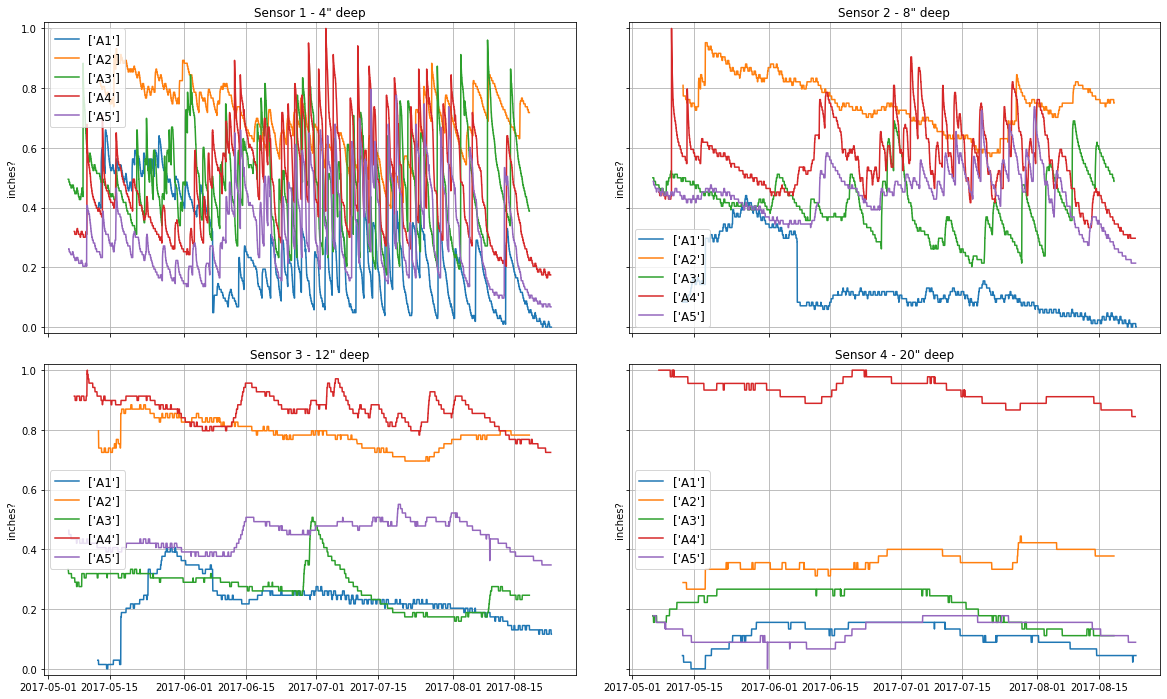

In [24]:
opc.plot_moistures_oneSensorAtaTime(A1_std, A2_std, A3_std, A4_std, A5_std, yLabel="inches?", xLabel="", )

file_name = plot_dir + "04_sensor_readings_per_sensor_STD.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# all_sensors.head(2)
# all_sensors_grouped_by_field = all_sensors.groupby('field')

In [ ]:
# rowlength = int(all_sensors_grouped_by_field.ngroups/2) + 1  # fix up if odd number of groups
# fig, axs = plt.subplots(figsize=(9,4), 
#                         nrows=2, ncols = rowlength,     # fix as above
#                         gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

# targets = zip(all_sensors_grouped_by_field.groups.keys(), axs.flatten())

# for i, (key, ax) in enumerate(targets):
#     ax.plot(all_sensors_grouped_by_field.get_group(key))
#     # ax.plot(all_sensors_grouped_by_field.get_group(key).Date.values, A5.Sensor1.values)
#     ax.set_title('a=%d'%key)
# ax.legend()
# plt.show()

# Rot Statistics
These are read from the file `harvest_sample_Rots_2017_fromCleaned2_2017_red_Onion_harvest_samples.xlsx`
which is copy of three columns in `CLEANED(2) 2017 Red Onion Harvest Samples.xlsx`

In [25]:
rot_file_Name = "harvest_sample_Rots_2017_fromCleaned2_2017_red_Onion_harvest_samples.xlsx"

rot_samples = pd.read_excel(io = python_data_dir + rot_file_Name)

In [26]:
rot_samples.head(2)

,Date,SampleDate,Field code,ExtDecayPercent,IntDecayPercent
0,2017-09-07,2017-09-07,A1,0.128735,0.071264
1,2017-09-08,2017-09-07,A1,0.105590,0.113871


In [27]:
rot_samples.ExtDecayPercent = rot_samples.ExtDecayPercent*100
rot_samples.IntDecayPercent = rot_samples.IntDecayPercent*100

In [28]:
rot_samples.head(2)

,Date,SampleDate,Field code,ExtDecayPercent,IntDecayPercent
0,2017-09-07,2017-09-07,A1,12.8735,7.1264
1,2017-09-08,2017-09-07,A1,10.5590,11.3871


In [29]:
stat1 = rot_samples.groupby(['Field code']).agg({'IntDecayPercent':[min, max, sum],
                                                 'ExtDecayPercent':[min, max, sum]
                                                 # 'network_type': "count",  # get the count of networks
                                                 # 'date': 'first'  # get the first date per group
                                                 })

stat1.to_csv(python_data_dir + "stat1_minMax.csv")

In [30]:
print (rot_samples.groupby('Field code')['IntDecayPercent'].mean())
print (rot_samples.groupby('Field code')['IntDecayPercent'].std())

print (rot_samples.groupby('Field code')['ExtDecayPercent'].mean())
print (rot_samples.groupby('Field code')['ExtDecayPercent'].std())

Field code
A1     7.304809
A2     3.151219
A3     4.896081
A4    25.547935
A5    15.148222
Name: IntDecayPercent, dtype: float64
Field code
A1     5.958048
A2     3.955659
A3     4.441099
A4    10.704856
A5     7.102745
Name: IntDecayPercent, dtype: float64
Field code
A1     4.766284
A2     1.920981
A3     2.948833
A4    12.491321
A5     8.277500
Name: ExtDecayPercent, dtype: float64
Field code
A1    5.137437
A2    2.745712
A3    3.232326
A4    6.395220
A5    5.222362
Name: ExtDecayPercent, dtype: float64


# Sum of all sensors 

In [31]:
def add_senrosrs_sum(a_df):
    a_df['sensors_sum'] = a_df['Sensor1'] + a_df['Sensor2'] + a_df['Sensor3'] + a_df['Sensor4']
    
def add_depths_contribution_columns(a_df):
    a_df['Sensor1_contribution'] = 100 * (a_df['Sensor1'] / a_df['sensors_sum'])
    a_df['Sensor2_contribution'] = 100 * (a_df['Sensor2'] / a_df['sensors_sum'])
    a_df['Sensor3_contribution'] = 100 * (a_df['Sensor3'] / a_df['sensors_sum'])
    a_df['Sensor4_contribution'] = 100 * (a_df['Sensor4'] / a_df['sensors_sum'])

In [32]:
add_senrosrs_sum(A1)
add_senrosrs_sum(A2)
add_senrosrs_sum(A3)
add_senrosrs_sum(A4)
add_senrosrs_sum(A5)

In [33]:
add_depths_contribution_columns(A1)
add_depths_contribution_columns(A2)
add_depths_contribution_columns(A3)
add_depths_contribution_columns(A4)
add_depths_contribution_columns(A5)

,Date,Sensor1,Sensor2,Sensor3,Sensor4,field,sensors_sum,Sensor1_contribution,Sensor2_contribution,Sensor3_contribution,Sensor4_contribution
0,2017-05-05 17:56:41,0.57,0.77,0.64,0.55,A5,2.53,22.529644,30.434783,25.296443,21.739130
1,2017-05-05 18:30:14,0.57,0.77,0.63,0.55,A5,2.52,22.619048,30.555556,25.000000,21.825397


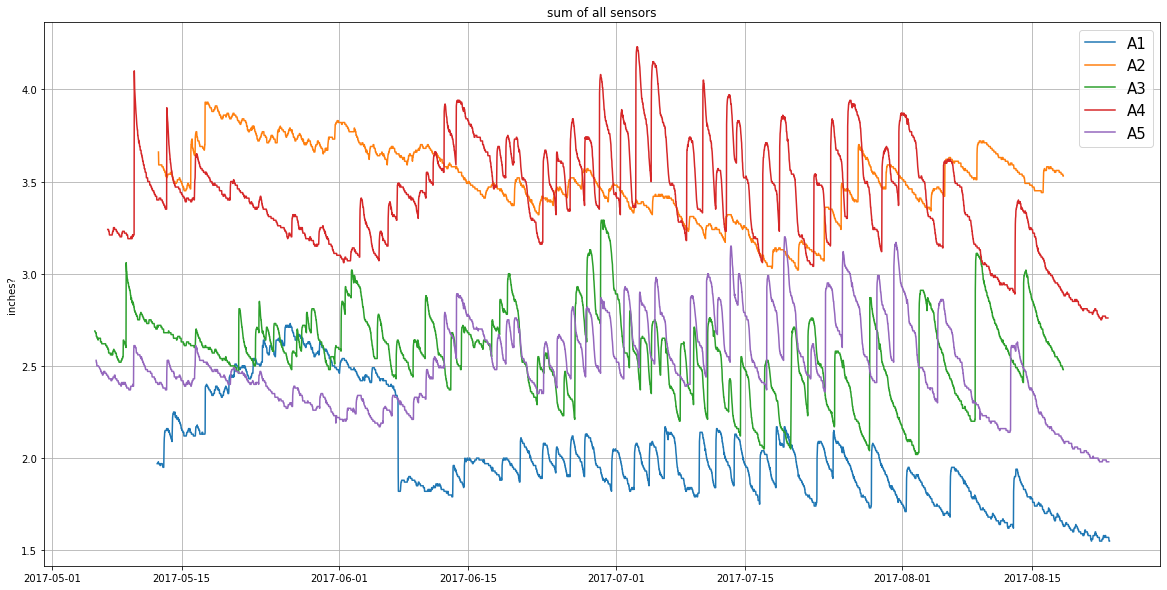

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.sensors_sum.values, label="A1")
ax1.plot(A2.Date.values, A2.sensors_sum.values, label="A2")
ax1.plot(A3.Date.values, A3.sensors_sum.values, label="A3")
ax1.plot(A4.Date.values, A4.sensors_sum.values, label="A4")
ax1.plot(A5.Date.values, A5.sensors_sum.values, label="A5")
ax1.legend(loc="best", fontsize=15);
ax1.set(ylabel="inches?")
ax1.set_title("sum of all sensors");

file_name = plot_dir + "05_sum_of_sensors.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [36]:
A1.head(2)

,Date,Sensor1,Sensor2,Sensor3,Sensor4,field,sensors_sum,Sensor1_contribution,Sensor2_contribution,Sensor3_contribution,Sensor4_contribution
0,2017-05-12 08:30:13,0.71,0.43,0.34,0.49,A1,1.97,36.040609,21.827411,17.258883,24.873096
1,2017-05-12 09:00:16,0.71,0.43,0.34,0.49,A1,1.97,36.040609,21.827411,17.258883,24.873096


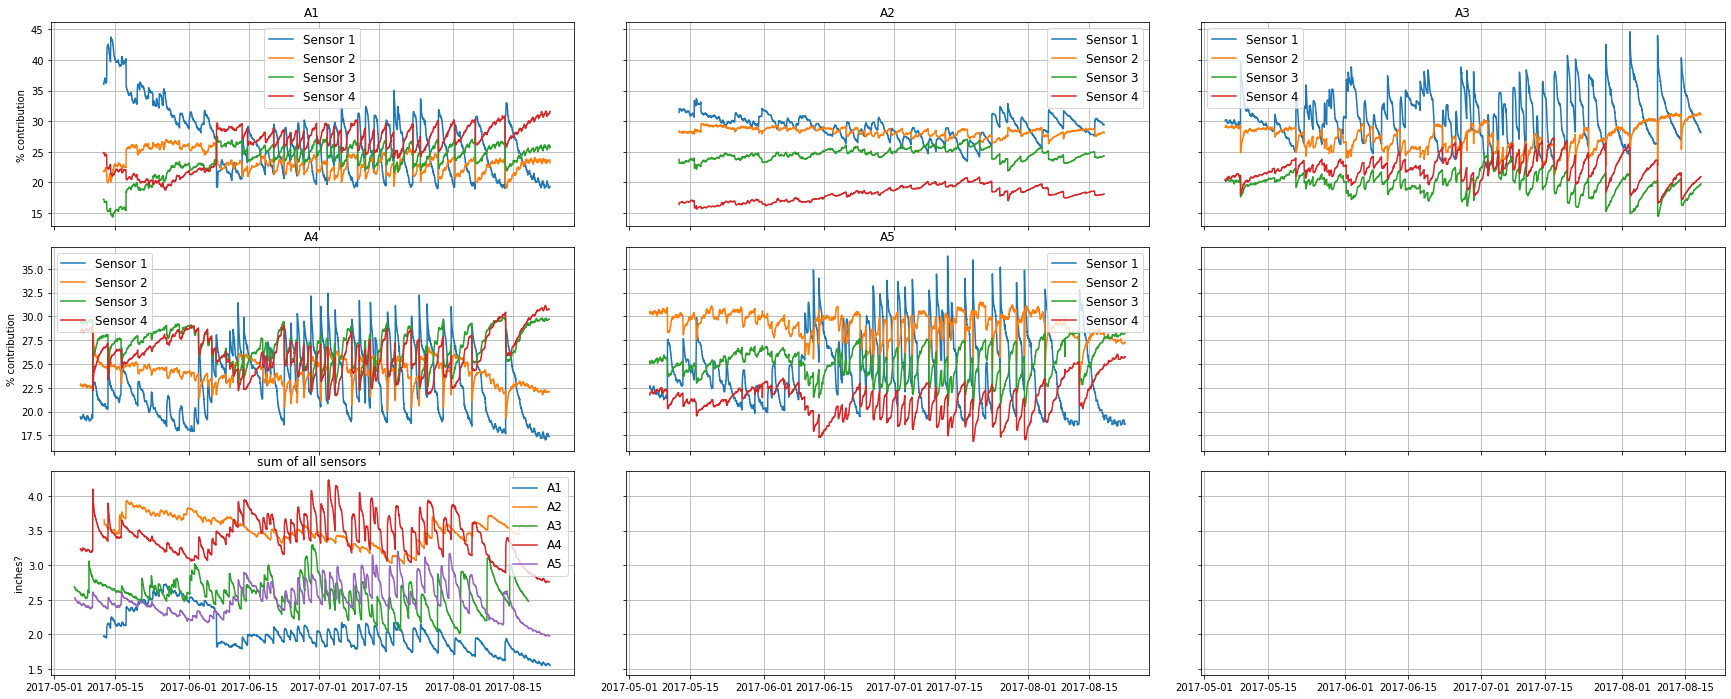

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(30,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); 
ax4.grid(True); ax5.grid(True); ax6.grid(True);
ax7.grid(True); ax8.grid(True); ax9.grid(True);

ax1.plot(A1.Date.values, A1.Sensor1_contribution.values, label="Sensor 1")
ax1.plot(A1.Date.values, A1.Sensor2_contribution.values, label="Sensor 2")
ax1.plot(A1.Date.values, A1.Sensor3_contribution.values, label="Sensor 3")
ax1.plot(A1.Date.values, A1.Sensor4_contribution.values, label="Sensor 4")
ax1.legend(loc="best", fontsize=12);
ax1.set_title("A1");
ax1.set(ylabel="% contribution")
#  ax1.ylim = (0, 1.2)
# ax1.set_ylim([0.2, 1.3])

ax2.plot(A2.Date.values, A2.Sensor1_contribution.values, label="Sensor 1")
ax2.plot(A2.Date.values, A2.Sensor2_contribution.values, label="Sensor 2")
ax2.plot(A2.Date.values, A2.Sensor3_contribution.values, label="Sensor 3")
ax2.plot(A2.Date.values, A2.Sensor4_contribution.values, label="Sensor 4")
ax2.legend(loc="best", fontsize=12);
ax2.set_title("A2");
# ax2.set_ylim([0.2, 1.3])

ax3.plot(A3.Date.values, A3.Sensor1_contribution.values, label="Sensor 1")
ax3.plot(A3.Date.values, A3.Sensor2_contribution.values, label="Sensor 2")
ax3.plot(A3.Date.values, A3.Sensor3_contribution.values, label="Sensor 3")
ax3.plot(A3.Date.values, A3.Sensor4_contribution.values, label="Sensor 4")
ax3.legend(loc="best", fontsize=12);
ax3.set_title("A3");

# ax3.set_ylim([0.2, 1.3])

ax4.plot(A4.Date.values, A4.Sensor1_contribution.values, label="Sensor 1")
ax4.plot(A4.Date.values, A4.Sensor2_contribution.values, label="Sensor 2")
ax4.plot(A4.Date.values, A4.Sensor3_contribution.values, label="Sensor 3")
ax4.plot(A4.Date.values, A4.Sensor4_contribution.values, label="Sensor 4")
ax4.legend(loc="best", fontsize=12);
ax4.set(ylabel="% contribution")
ax4.set_title("A4");
# ax4.set_ylim([0.2, 1.3])

ax5.plot(A5.Date.values, A5.Sensor1_contribution.values, label = "Sensor 1")
ax5.plot(A5.Date.values, A5.Sensor2_contribution.values, label = "Sensor 2")
ax5.plot(A5.Date.values, A5.Sensor3_contribution.values, label = "Sensor 3")
ax5.plot(A5.Date.values, A5.Sensor4_contribution.values, label = "Sensor 4")
ax5.legend(loc="best", fontsize=12);
ax5.set_title("A5");
# ax5.set_ylim([0.2, 1.3])


ax7.plot(A1.Date.values, A1.sensors_sum.values, label="A1")
ax7.plot(A2.Date.values, A2.sensors_sum.values, label="A2")
ax7.plot(A3.Date.values, A3.sensors_sum.values, label="A3")
ax7.plot(A4.Date.values, A4.sensors_sum.values, label="A4")
ax7.plot(A5.Date.values, A5.sensors_sum.values, label="A5")
ax7.legend(loc="best", fontsize=12);
ax7.set(ylabel="inches?")
ax7.set_title("sum of all sensors");
# ax6.ylim = (0, 4.2)
# ax6.set_ylim([1.3, 4.3])

file_name = plot_dir + "06_sum_and_contributions.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

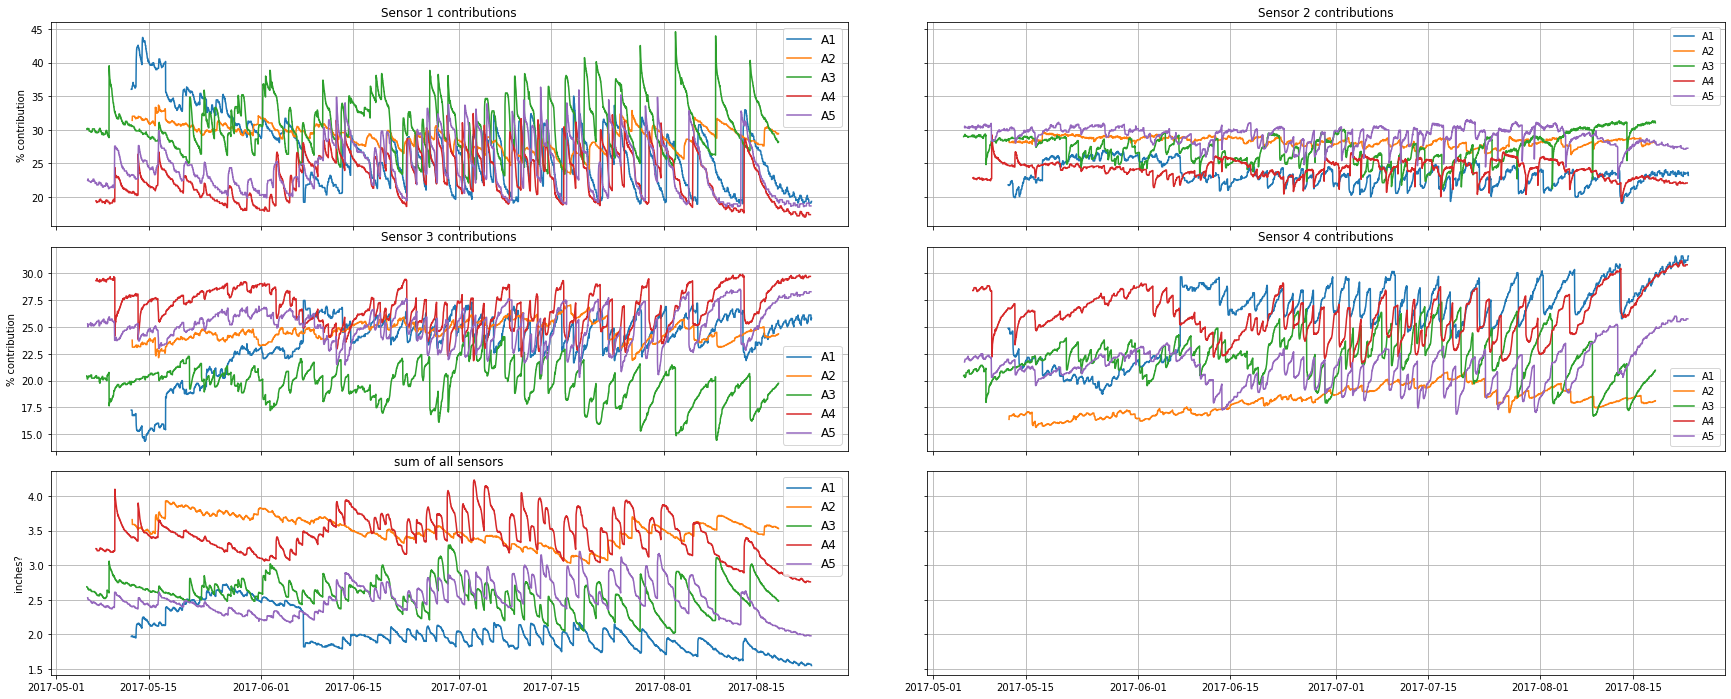

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(30,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); 
ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.Sensor1_contribution.values, label="A1")
ax1.plot(A2.Date.values, A2.Sensor1_contribution.values, label="A2")
ax1.plot(A3.Date.values, A3.Sensor1_contribution.values, label="A3")
ax1.plot(A4.Date.values, A4.Sensor1_contribution.values, label="A4")
ax1.plot(A5.Date.values, A5.Sensor1_contribution.values, label="A5")
ax1.legend(loc="best", fontsize=12);
ax1.set(ylabel="% contribution")
ax1.set_title("Sensor 1 contributions");
#  ax1.ylim = (0, 1.2)
# ax1.set_ylim([0.2, 1.3])

ax2.plot(A1.Date.values, A1.Sensor2_contribution.values, label="A1")
ax2.plot(A2.Date.values, A2.Sensor2_contribution.values, label="A2")
ax2.plot(A3.Date.values, A3.Sensor2_contribution.values, label="A3")
ax2.plot(A4.Date.values, A4.Sensor2_contribution.values, label="A4")
ax2.plot(A5.Date.values, A5.Sensor2_contribution.values, label="A5")
ax2.legend(loc="best");
ax2.set_title("Sensor 2 contributions");
# ax2.set_ylim([0.2, 1.3])

ax3.plot(A1.Date.values, A1.Sensor3_contribution.values, label="A1")
ax3.plot(A2.Date.values, A2.Sensor3_contribution.values, label="A2")
ax3.plot(A3.Date.values, A3.Sensor3_contribution.values, label="A3")
ax3.plot(A4.Date.values, A4.Sensor3_contribution.values, label="A4")
ax3.plot(A5.Date.values, A5.Sensor3_contribution.values, label="A5")
ax3.legend(loc="best", fontsize=12);
ax3.set(ylabel="% contribution")
ax3.set_title("Sensor 3 contributions");
# ax3.set_ylim([0.2, 1.3])

ax4.plot(A1.Date.values, A1.Sensor4_contribution.values, label="A1")
ax4.plot(A2.Date.values, A2.Sensor4_contribution.values, label="A2")
ax4.plot(A3.Date.values, A3.Sensor4_contribution.values, label="A3")
ax4.plot(A4.Date.values, A4.Sensor4_contribution.values, label="A4")
ax4.plot(A5.Date.values, A5.Sensor4_contribution.values, label="A5")
ax4.legend(loc="best");
ax4.set_title("Sensor 4 contributions");
# ax4.set_ylim([0.2, 1.3])


ax5.plot(A1.Date.values, A1.sensors_sum.values, label="A1")
ax5.plot(A2.Date.values, A2.sensors_sum.values, label="A2")
ax5.plot(A3.Date.values, A3.sensors_sum.values, label="A3")
ax5.plot(A4.Date.values, A4.sensors_sum.values, label="A4")
ax5.plot(A5.Date.values, A5.sensors_sum.values, label="A5")
ax5.legend(loc="best", fontsize=12);
ax5.set(ylabel="inches?")
ax5.set_title("sum of all sensors");
# ax6.ylim = (0, 4.2)
# ax6.set_ylim([1.3, 4.3])

file_name = plot_dir + "07_sum_and_contributions.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

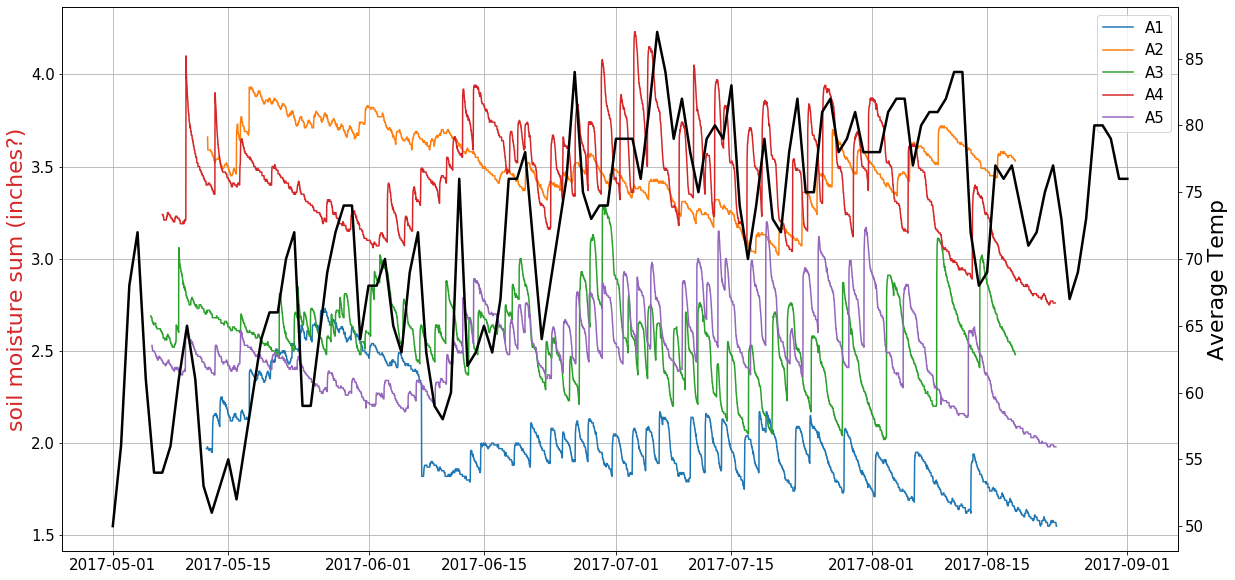

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.sensors_sum.values, label="A1")
ax1.plot(A2.Date.values, A2.sensors_sum.values, label="A2")
ax1.plot(A3.Date.values, A3.sensors_sum.values, label="A3")
ax1.plot(A4.Date.values, A4.sensors_sum.values, label="A4")
ax1.plot(A5.Date.values, A5.sensors_sum.values, label="A5")
ax1.legend(loc="best", fontsize=15);
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.set_ylabel('soil moisture sum (inches?)', color='tab:red', fontsize = 22)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('Average Temp', color='black', fontsize = 22)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax2.plot(ABC_2016_2017_small_TW.Date.values, 
         ABC_2016_2017_small_TW["Average Temp (F)"].values, 
         label="Average Temp",
         color='black', 
         linewidth=2.5)

file_name = plot_dir + "08_sum_of_sensors_Temp.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

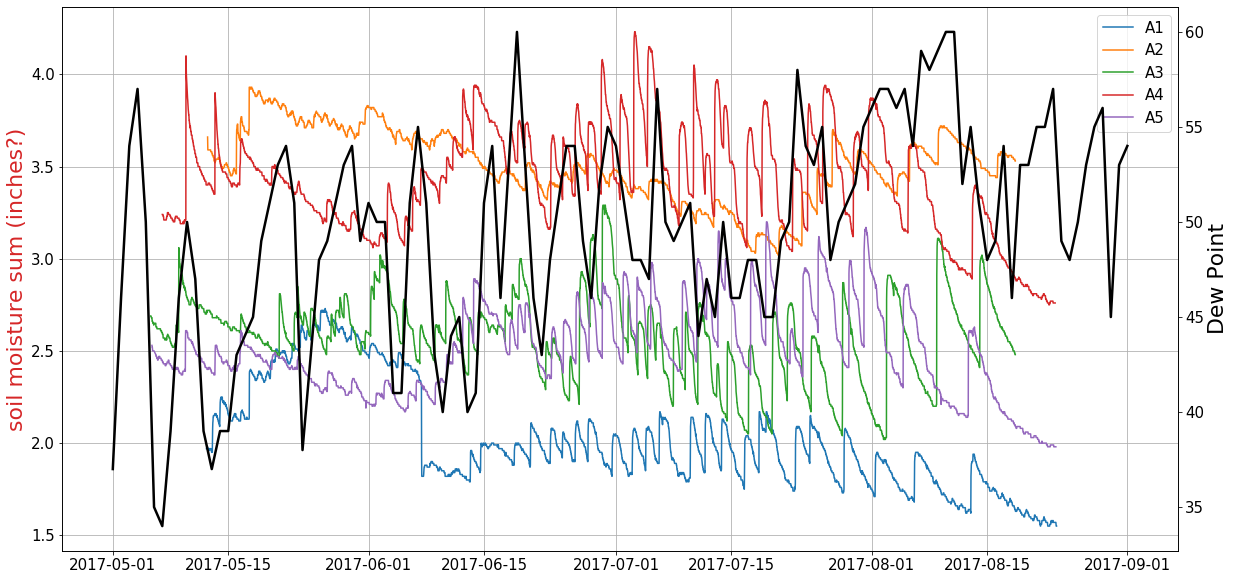

In [40]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.sensors_sum.values, label="A1")
ax1.plot(A2.Date.values, A2.sensors_sum.values, label="A2")
ax1.plot(A3.Date.values, A3.sensors_sum.values, label="A3")
ax1.plot(A4.Date.values, A4.sensors_sum.values, label="A4")
ax1.plot(A5.Date.values, A5.sensors_sum.values, label="A5")
ax1.legend(loc="best", fontsize=15);
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.set_ylabel('soil moisture sum (inches?)', color='tab:red', fontsize = 22)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('Dew Point', color='black', fontsize = 22)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax2.plot(ABC_2016_2017_small_TW.Date.values, 
         ABC_2016_2017_small_TW["Dew Point"].values, 
         label="Dew Point",
         color = 'black',
         linewidth=2.5)

file_name = plot_dir + "09_sum_of_sensors_Dew_Point.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
ABC_2016_2017_small_TW.head(1)

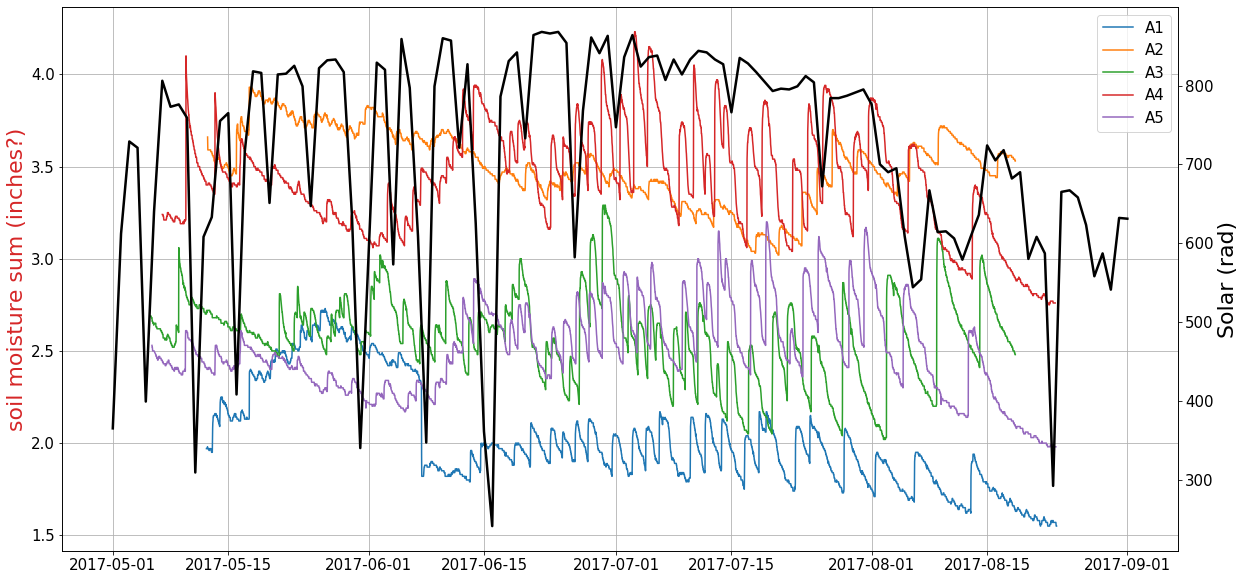

In [41]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.sensors_sum.values, label="A1")
ax1.plot(A2.Date.values, A2.sensors_sum.values, label="A2")
ax1.plot(A3.Date.values, A3.sensors_sum.values, label="A3")
ax1.plot(A4.Date.values, A4.sensors_sum.values, label="A4")
ax1.plot(A5.Date.values, A5.sensors_sum.values, label="A5")
ax1.legend(loc="best", fontsize=15);
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.set_ylabel('soil moisture sum (inches?)', color='tab:red', fontsize = 22)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('Solar (rad)', color='black', fontsize = 22)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax2.plot(ABC_2016_2017_small_TW.Date.values, 
         ABC_2016_2017_small_TW["Solar (rad)"].values, 
         label="Solar (rad)",
         color = 'black',
         linewidth=2.5)

file_name = plot_dir + "10_sum_of_sensors_Solar_rad.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

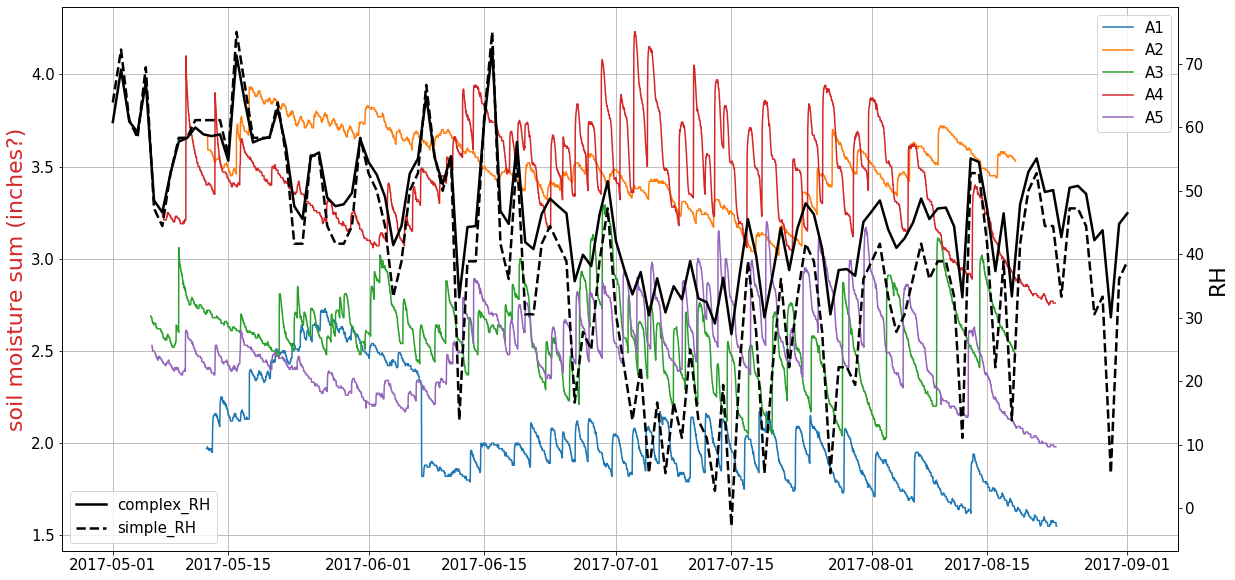

In [119]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.sensors_sum.values, label="A1")
ax1.plot(A2.Date.values, A2.sensors_sum.values, label="A2")
ax1.plot(A3.Date.values, A3.sensors_sum.values, label="A3")
ax1.plot(A4.Date.values, A4.sensors_sum.values, label="A4")
ax1.plot(A5.Date.values, A5.sensors_sum.values, label="A5")
ax1.legend(loc="upper right", fontsize=15);
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.set_ylabel('soil moisture sum (inches?)', color='tab:red', fontsize = 22)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('RH', color='black', fontsize = 22)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax2.plot(ABC_2016_2017_small_TW.Date.values, 
         ABC_2016_2017_small_TW["complex_RH"].values, 
         label="complex_RH",
         color = 'black',
         linewidth=2.5)

ax2.plot(ABC_2016_2017_small_TW.Date.values, 
         ABC_2016_2017_small_TW["simple_RH"].values, 
         linestyle = '--',
         label="simple_RH",
         color = 'black',
         linewidth=2.5)

ax2.legend(loc="lower left", fontsize=15);

file_name = plot_dir + "10_sum_of_sensors_RH.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [96]:
ABC_2016_2017_small_TW["Dew Point"].unique()

array([37., 46., 54., 57., 50., 35., 34., 39., 47., 43., 44., 45., 49.,
       51., 53., 38., 48., 41., 55., 40., 60., 52., 58., 56., 59.])

In [42]:
ABC_2016_2017_small_TW.head(3)

,Date,Max Temp (F),Min Temp (F),Average Temp (F),Dew Point,Rain (Inch),Wind (Miles),Solar (rad),ETp,GDD,month,year,Avg_Temp_C,Dew_Point_C,simple_RH,complex_RH
181,2017-05-01 00:00:00,60,40,50,37.0,0,140,365,0.14,5.15,5,2017,10,2.777778,63.8889,60.813095
182,2017-05-02 00:00:00,69,44,56,46.0,0,63,612,0.14,9.35,5,2017,13.3333,7.777778,72.2222,69.067460
183,2017-05-03 00:00:00,83,53,68,54.0,0,52,729,0.19,18,5,2017,20,12.222222,61.1111,60.884173


In [ ]:
# fig = plt.figure(figsize=(15,5))

# cx0 = fig.add_subplot(121)
# cx1 = cx0.twinx()
# cx2 = plt.subplot(122)
# cx3 = cx2.twinx()

# rate_amnt_byGrade['loan_amnt'].plot(kind='bar', ax=cx0)
# rate_amnt_byGrade['dti'].plot(ax=cx1, secondary_y=True)
# rate_amnt_byGrade['int_rate'].plot(kind='bar', ax=cx2)
# rate_amnt_byGrade['dti'].plot(ax=cx3, secondary_y=True)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW['Average Temp (F)'].values, label="Avg. Temp.")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW['Dew Point'].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW['Wind (Miles)'].values, label="Wind (Miles)")
ax1.legend(loc="best", fontsize=17);
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.set_title("Weather data");

file_name = plot_dir + "11_weather_data.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW['Solar (rad)'].values, label="Solar (rad)")
ax1.legend(loc="best", fontsize=17);
ax1.tick_params(axis='y', which='major', labelsize=12)
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.set_ylabel('rad', fontsize = 22)

ax1.set_title("Solar data");

file_name = plot_dir + "12_Solar_rad.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")
ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

# ax1.set_title("weather data");


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A1 soil moisture sum', color='black', fontsize = 22)
ax2.plot(A1.Date.values, A1.sensors_sum.values, label="A1", 
         color = 'black', linewidth=2.5)
ax2.tick_params(axis='y', which='major', labelsize=15)

# ax2.plot(ABC_2016_2017_small_TW.Date.values, 
#          ABC_2016_2017_small_TW["Solar (rad)"].values, 
#          label="Solar (rad)",
#          color = 'black')

file_name = plot_dir + "13_weather_sensos_sum_A1.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

# ax1.set_title("weather data");


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A2 soil moisture sum', color='black', fontsize = 22)
ax2.plot(A2.Date.values, A2.sensors_sum.values, label="A2", 
         color = 'black', linewidth=2.5)
ax2.tick_params(axis='y', which='major', labelsize=15)

# ax2.plot(ABC_2016_2017_small_TW.Date.values, 
#          ABC_2016_2017_small_TW["Solar (rad)"].values, 
#          label="Solar (rad)",
#          color = 'black')

file_name = plot_dir + "14_weather_sensos_sum_A2.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

# ax1.set_title("weather data");


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A3 soil moisture sum', color='black', fontsize = 22)
ax2.plot(A3.Date.values, A3.sensors_sum.values, label="A3",  
         color = 'black', linewidth=2.5)
ax2.tick_params(axis='y', which='major', labelsize=15)

# ax2.plot(ABC_2016_2017_small_TW.Date.values, 
#          ABC_2016_2017_small_TW["Solar (rad)"].values, 
#          label="Solar (rad)",
#          color = 'black')

file_name = plot_dir + "15_weather_sensos_sum_A3.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
# ax1.set_title("weather data");


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A4 soil moisture sum', color='black', fontsize = 22)
ax2.plot(A4.Date.values, A4.sensors_sum.values, label="A4",  
         color = 'black', linewidth=2.5)
ax2.tick_params(axis='y', which='major', labelsize=15)

# ax2.plot(ABC_2016_2017_small_TW.Date.values, 
#          ABC_2016_2017_small_TW["Solar (rad)"].values, 
#          label="Solar (rad)",
#          color = 'black')

file_name = plot_dir + "16_weather_sensos_sum_A4.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
# ax1.set_title("weather data");


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A5 soil moisture sum', color='black', fontsize = 22)
ax2.plot(A5.Date.values, A5.sensors_sum.values, label="A5",  
         color = 'black', linewidth=2.5)
ax2.tick_params(axis='y', which='major', labelsize=15)

# ax2.plot(ABC_2016_2017_small_TW.Date.values, 
#          ABC_2016_2017_small_TW["Solar (rad)"].values, 
#          label="Solar (rad)",
#          color = 'black')

file_name = plot_dir + "17_weather_sensos_sum_A5.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)
# ax1.set_title("weather data");


ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A1 sensor 4', color='black', fontsize = 22)
ax2.plot(A1.Date.values, A1.Sensor4.values, label="A1",  
         color = 'black', linewidth=2.5)
ax2.tick_params(axis='y', which='major', labelsize=15)

ax2.set_ylim([0.46, 0.93])

file_name = plot_dir + "18_weather_sensor4_A1.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
A1.head(2)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
# ax1.set_title("weather data");
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A2 sensor 4', color='black', fontsize = 22)
ax2.plot(A2.Date.values, A2.Sensor4.values, label="A2", color = 'black', linewidth=2.5)
ax2.set_ylim([0.46, 0.93])
ax2.tick_params(axis='y', which='major', labelsize=15)

file_name = plot_dir + "19_weather_sensor4_A2.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
# ax1.set_title("weather data");
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A3 sensor 4', color='black', fontsize = 22)
ax2.plot(A3.Date.values, A3.Sensor4.values, label="A3", color = 'black', linewidth=2.5)
ax2.set_ylim([0.46, 0.93])
ax2.tick_params(axis='y', which='major', labelsize=15)


file_name = plot_dir + "20_weather_sensor4_A3.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=16);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
# ax1.set_title("weather data");
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A4 sensor 4', color='black', fontsize = 22)
ax2.plot(A4.Date.values, A4.Sensor4.values, label="A4", color = 'black', linewidth=2.5)
ax2.set_ylim([0.46, 0.93])
ax2.tick_params(axis='y', which='major', labelsize=15)

file_name = plot_dir + "21_weather_sensor4_A4.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Solar (rad)"].values, label="Solar (rad)")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Dew Point"].values, label="Dew Point")
ax1.plot(ABC_2016_2017_small_TW.Date.values, ABC_2016_2017_small_TW["Wind (Miles)"].values, label="Wind (Miles)")

ax1.legend(loc="best", fontsize=17);
ax1.set_ylabel('weather data', color='tab:red', fontsize = 22)
# ax1.set_title("weather data");
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# we already handled the x-label with ax1
ax2.set_ylabel('A5 sensor 4', color='black', fontsize = 22)
ax2.plot(A5.Date.values, A5.Sensor4.values, label="A5", color = 'black', linewidth=2.5)
ax2.set_ylim([0.46, 0.93])
ax2.tick_params(axis='y', which='major', labelsize=15)

file_name = plot_dir + "22_weather_sensor4_A5.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Scratch below

In [ ]:
# ts = pd.Series(np.random.randn(1000),
#                 index=pd.date_range('1/1/2000', periods=1000))
# ts = ts.cumsum()
    
# df = pd.DataFrame(np.random.randn(1000, 4),
#                    index=ts.index, columns=list('ABCD'))

# df.head(2)

# df = df.cumsum()
# df.head(2)

# plt.figure();
# df.plot();

In [62]:
mylist = [1, 2, 3, 4, 5, 6, 7]
N = 3
cumsum, moving_aves = [0], []

for i, x in enumerate(mylist, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

In [64]:
len(moving_aves)

5

In [ ]:
df = pd.DataFrame(np.random.randint(0, 10,(200,6)),columns=list('abcdef'))
grouped = df.groupby('a')

df = pd.DataFrame(np.random.randint(0,10,(200,6)),columns=list('abcdef'))
grouped = df.groupby('a')
rowlength = int(grouped.ngroups/2)  # fix up if odd number of groups

fig, axs = plt.subplots(figsize=(18, 8),
                        nrows=2, ncols=rowlength,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key))
    ax.set_title('a=%d'%key)
# ax.legend()
plt.show()

In [105]:
sof_hyphen = oc.read_ABC_weather_XLSfile(an_add_fileName = python_data_dir + "ABC_Correct.xlsx", 
                                         header_rows = 1, 
                                         skip_Rows = 3)

sof_hyphen.head(2)

,Date,Max Temp (F),Min Temp (F),Average Temp (F),Dew Point,Rain (Inch),Wind (Miles),Solar (rad),ETp,GDD
0,2016-11-01 00:00:00,63,41,52,43,0,99,303,0.07,6.35
1,2016-11-02 00:00:00,64,41,53,44,0,28,272,0.05,7.15


In [110]:
sof_hyphen.loc[46, "Dew Point"]

'\xad1'

In [77]:
for ii

In [81]:
import re
re.sub('\xad','', sof_hyphen["Dew Point"].unique()[35])

'0'

In [84]:
sof_hyphen["Dew Point"].unique()

array(['43', '44', '46', '45', '47', '48', '34', '33', '38', '35', '28',
       '39', '36', '32', '29', '26', '24', '15', '14', '20', '18', '23',
       '27', '12', '16', '7', '1', '22', '25', '30', '17', '9', '2', '4',
       '21', '0', '6', '5', '11', '19', '42', '40', '37', '41', '31',
       '54', '57', '50', '49', '51', '53', '55', '60', '52', '58', '56',
       '59'], dtype=object)

In [86]:
sof_hyphen["Dew Point"].unique()

6.0

In [ ]:
ABC_2016_2017["Dew Point"] = ABC_2016_2017["Dew Point"].astype(float)

ABC_2016_2017["Dew Point"].astype(float)

##
## Add celsuis stuff to compute Relative Humidity.
## 
ABC_2016_2017["Avg_Temp_C"] = (ABC_2016_2017["Average Temp (F)"] - 32 ) * (5/9)
ABC_2016_2017["Dew_Point_C"] = (ABC_2016_2017["Dew Point"] - 32 ) * (5/9) 


In [ ]:
df1 = A1[['Date', "A1_sensor_1"]]
df2 = A2[['Date', "A2_sensor_1"]]

AA = pd.concat([df2, df2], axis=1, sort=True)

In [ ]:
AA.head(2)

In [ ]:
pd.concat([df1, df4], axis=1, sort=True)

In [ ]:
pd.concat([df1, df4], axis=1, sort=True) == pd.concat([df1, df4], axis=1, sort=False)